**PyMLDA Code in the Context of the WeDoWind ASCE-EMI Structural Health Monitoring for Wind Energy Challenge**

**Title:** Failure classification in the Aventa wind turbine during operation using PyMLDA Open-Code (ID4)

The Aventa operational monitoring model using PyMLDA consists of eight steps:

1- Data acquisition

2- Data pre-processing  

3- Feature selection

4- Feature sensitivity and normalization

5- Unsupervised classification and clustering

6- Data splitting

7- Metric evaluation

8- Model Evaluation



**Open access to the PyMLDA**: https://github.com/mromarcela/PyMLDA

**Authors:** M.R.Machado, J.C. da Silva, A.A.R. de Sousa

University of Brasilia, Brazil

**1-Data Processing**: The initial stage involves collecting data from the monitored structure, the wind turbine Aventa AG. This process was done in separade file for sake of computaitonal efficiency.
    
**2-Data pre-processing:** This data-driven approach requires understanding and examining inherent data features before integrating them into the machine learning model for accurate classification and estimation. This step includes analysing the spectrum response of the structure, where specific sensor outcomes are verified and selected. The detailed process adopted in this stage is given in Section 2 of the report.

#3 Feature selection

In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Fourteen techniques are applied to extract features from the time-domain signal, $x(t)$, including:
* Maximum value of $x(t)$
* Minimum value of $x(t)$
* Amplitude range: $\operatorname{max}[x(t)]-\operatorname{min}[x(t)]$
* Median value of $x(t)$
* Mean value of $x(t)$
* Variance of $x(t)$
* Energy of the centred signal: $E_{c}=\sum_{k=1}^{N}\left(x_{k}-\operatorname{mean}(x)\right)^{2}$
* Signal rate: $\tau=\frac{\max \left(x_{k=1: N}\right)-\min \left(x_{k=1: N}\right)}{\operatorname{mean}(x)}$



Those features are organised in the dataset
- datasetNO: Normal Operation
- datasetFC: Coupling Failure
- datasetRI: Rotor Icing
- datasetAI: Aerodynamic Imbalance

In [2]:
# Reading the Excel files representing different operating conditions:
# - datasetNO: Normal Operation
# - datasetFC: Coupling Failure
# - datasetRI: Rotor Icing
# - datasetAI: Aerodynamic Imbalance
#Zs is the Y of the turbine - side to side vibration
#Ys is the X of the turbine - fore-aft vibration

# Data is read from the "Ys" sheet in each file
datasetNO = pd.read_excel('Aventa_Dataset_Features_Xs_Ys_Zs - Normal_operation.xlsx', sheet_name='Ys')
datasetFC = pd.read_excel('Aventa_Dataset_Features_Xs_Ys_Zs - Failure_coupling.xlsx', sheet_name='Ys')
datasetRI = pd.read_excel('Aventa_Dataset_Features_Xs_Ys_Zs - Rotor_icing_mod.xlsx', sheet_name='Ys')
datasetAI = pd.read_excel('Aventa_Dataset_Features_Xs_Ys_Zs - Aerodynamic_imbalance_Mod.xlsx', sheet_name='Ys')

# Putting the DataFrames into a list for easy batch processing
dataframes = [datasetNO, datasetFC, datasetRI, datasetAI]

# Removing unnecessary columns from each DataFrame
for dataset in dataframes:
    dataset.drop(['Item','Aventa Metadado', 'File'], axis=1, inplace=True)

#4- Feature selection and normalisation

In [3]:
import numpy as np
import pandas as pd

# Dicionário para armazenar os DataFrames normalizados com nomes específicos
normalized_dataframes = {}

# Nomes específicos para cada condição de operação
dataset_names = ['df_normalized_NO', 'df_normalized_FC', 'df_normalized_RI', 'df_normalized_AI']

# Loop para normalizar cada DataFrame em 'dataframes'
for df, name in zip(dataframes, dataset_names):
    # Identificar as colunas numéricas no DataFrame atual
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
    df_normalized = df.copy()  # Criar uma cópia do DataFrame para manter os dados originais

    # Aplicar a normalização delta a cada coluna numérica
    for column in numerical_columns:
        max_value = np.max(df[column])  # Valor máximo na coluna
        delta = max_value - df[column]  # Calcular delta
        df_normalized[column] = delta / np.max(delta)  # Normalização delta

    # Aplicar a inversão nas colunas específicas
    for column in ['Min', 'Median', 'RMS']:
        df_normalized[column] = 1 - df_normalized[column]  # Inversão

    # Adicionar o DataFrame normalizado ao dicionário com o nome específico
    normalized_dataframes[name] = df_normalized


In [4]:
# Combine all normalized DataFrames (Normal Operation, Coupling Failure, Rotor Icing, and Aerodynamic Imbalance) into a single DataFrame
dataset_all = pd.concat([normalized_dataframes['df_normalized_NO'], normalized_dataframes['df_normalized_FC'],
                         normalized_dataframes['df_normalized_RI'], normalized_dataframes['df_normalized_AI']],
                        axis=0, ignore_index=True)

# Combine the normalized DataFrames for Normal Operation and Coupling Failure
dataset_NO_FC = pd.concat([normalized_dataframes['df_normalized_NO'], normalized_dataframes['df_normalized_FC']],
                           axis=0, ignore_index=True)

# Combine the normalized DataFrames for Normal Operation and Rotor Icing
dataset_NO_RI = pd.concat([normalized_dataframes['df_normalized_NO'], normalized_dataframes['df_normalized_RI']],
                           axis=0, ignore_index=True)

# Combine the normalized DataFrames for Normal Operation and Aerodynamic Imbalance
dataset_NO_AI = pd.concat([normalized_dataframes['df_normalized_NO'], normalized_dataframes['df_normalized_AI']],
                           axis=0, ignore_index=True)

# Results
print("Dataset all:", dataset_all.shape)
print("\nDataset Normal Operation + Failure Coupling:", dataset_NO_FC.shape)
print("\nDataset Normal Operation + Rotor Icing:", dataset_NO_RI.shape)
print("\nDataset Normal Operation + Aerodynamic Imbalance:", dataset_NO_AI.shape)

Dataset all: (3114, 15)

Dataset Normal Operation + Failure Coupling: (1744, 15)

Dataset Normal Operation + Rotor Icing: (1292, 15)

Dataset Normal Operation + Aerodynamic Imbalance: (970, 15)


#5- Unsupervised classification and clustering (K-means)

The PyMLDA allows for two types of analysis: binary classification and multiclass classification. Depending on the selected analysis, some adjustments are required:

A. Select the dataset strategy.

B. Set the number of K-means clusters (k=2 for binary classification and k=4 for multiclass).

C. Define custom labels and colors for the clusters.


In [5]:
#Importing libraries
from sklearn.cluster import KMeans

In [6]:
##Dataset strategy.
configurations = {
    "multiclass": {
        "dataset": dataset_all,
        "columns": ['Max', 'Min', 'Amplitude', 'RMS', 'Median', 'Variance', 'Energy Center', 'Signal rate', 'Label'],
        "cluster_names": {0: 'RI', 1: 'NO', 2:'FC', 3: 'AI'},
        "colors": ['#FF7F0E', '#6A0DAD','#1f77b4','#FFD000']
    },
    "binary_NO_FC": {
        "dataset": dataset_NO_FC,
        "columns": ['Max', 'Min', 'Amplitude', 'RMS', 'Median', 'Variance', 'Energy Center', 'Signal rate', 'Label'],
        "cluster_names": {0: 'FC'  , 1:'NO'},
        "colors": ['#FF7F0E','#1f77b4' ]
    },
    "binary_NO_RI": {
        "dataset": dataset_NO_RI,
        "columns": ['Max', 'Min', 'Amplitude', 'RMS', 'Median', 'Variance', 'Energy Center', 'Signal rate', 'Label'],
        "cluster_names": {0: 'NO', 1: 'RI'},
        "colors": [ '#FFD000', '#1f77b4']
    },
    "binary_NO_AI": {
        "dataset": dataset_NO_AI,
        "columns": ['Max', 'Min', 'Amplitude', 'RMS', 'Median', 'Variance', 'Energy Center', 'Signal rate', 'Label'],
        "cluster_names": {0: 'AI', 1: 'NO'},
        "colors": ['#6A0DAD', '#1f77b4' ]
    }
}

In [7]:
##--> A. Select the dataset strategy.
selected_config = configurations["binary_NO_AI"]

# Load dataset and settings
dataset = selected_config["dataset"].copy()
columns = selected_config["columns"]
cluster_names = selected_config["cluster_names"]
colors = selected_config["colors"]
if 'Label' in dataset.columns:
    dataset.drop(['Label'], axis=1, inplace=True)

#-->  B. Fitting K-Means with the chosen number of clusters
k = 2 # Number of clusters (used k= 4 for multiclass or  k=2 for binary)
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=0)

# Fit and predict clusters
labels = kmeans.fit_predict(dataset)
dataset['Label'] = labels

# Replace numeric labels with cluster names
dataset['Label'] = dataset['Label'].map(cluster_names)
cluster_groups = {cluster: dataset[dataset['Label'] == cluster] for cluster in dataset['Label'].unique()}
print(dataset.head())


        Max       Min  Amplitude    Median      Mean  Variance    Energy  \
0  0.829141  0.781271   0.813514  0.264728  0.736957  0.850944  0.010042   
1  0.839263  0.813217   0.833909  0.280855  0.709938  0.820327  1.000000   
2  0.841206  0.778495   0.818747  0.244727  0.767875  0.833390  0.010509   
3  0.813324  0.816775   0.821532  0.231756  0.757468  0.828239  0.010541   
4  0.877254  0.845797   0.869681  0.412326  0.597262  0.888964  0.008213   

   Energy Center  Skewness  Kurtosis  Moment order  Shannon Entropy  \
0       0.850930  0.642899  0.940588      0.996237         0.000278   
1       0.937073  0.648467  0.946320      0.997234         1.000000   
2       0.833381  0.653239  0.937907      0.996399         0.000313   
3       0.828249  0.637517  0.947712      0.997421         0.000425   
4       0.888959  0.659558  0.953094      0.997887         0.000320   

   Signal rate       RMS Label  
0     0.813592  0.265916    NO  
1     0.833998  0.294216    NO  
2     0.818797  0

Next two sections split the dataset for the feature correlation plot.

In [8]:
# Split column DataFrames for each cluster
split_datasets = {}

# Definindo as colunas desejadas
desired_columns = ['Max', 'Min', 'Amplitude', 'RMS', 'Median', 'Variance', 'Energy Center', 'Signal rate']

# Defining the desired columns
for cluster, cluster_data in cluster_groups.items():
    split_columns_df = pd.DataFrame()

    # Loop through the columns (excluding the 'Label' column)
    for col in cluster_data.columns:
        if col in ['Label']:  # Ignore column 'Label'
            continue
        if col in desired_columns:  # Filter only the desired columns
            half_point = len(cluster_data[col]) // 2
            split_columns_df[f'{col}-1'] = cluster_data[col].iloc[:half_point].reset_index(drop=True)
            split_columns_df[f'{col}-2'] = cluster_data[col].iloc[half_point:].reset_index(drop=True)

    # Re-adding the 'Label' column to the split DataFrame
    split_columns_df['Label'] = cluster_data['Label'].iloc[:len(split_columns_df)].reset_index(drop=True)

    # Storing the split data
    split_datasets[cluster] = split_columns_df

# Combining all split DataFrames into a single DataFrame
combined_ = pd.concat([dataset for dataset in split_datasets.values()], ignore_index=True)
combined_


,Max-1,Max-2,Min-1,Min-2,Amplitude-1,Amplitude-2,Median-1,Median-2,Variance-1,Variance-2,Energy Center-1,Energy Center-2,Signal rate-1,Signal rate-2,RMS-1,RMS-2,Label
0,0.829141,0.763546,0.781271,0.787838,0.813514,0.760677,0.264728,0.490028,0.850944,0.674092,0.850930,0.665900,0.813592,0.760996,0.265916,0.514938,NO
1,0.839263,0.816964,0.813217,0.832522,0.833909,0.812841,0.280855,0.425672,0.820327,0.728709,0.937073,0.719886,0.833998,0.813016,0.294216,0.446543,NO
2,0.841206,0.771472,0.778495,0.791571,0.818747,0.766719,0.244727,0.344426,0.833390,0.652517,0.833381,0.644628,0.818797,0.766843,0.235555,0.372043,NO
3,0.813324,0.663346,0.816775,0.731268,0.821532,0.678796,0.231756,0.142047,0.828239,0.750168,0.828249,0.741087,0.821590,0.678643,0.246200,0.146163,NO
4,0.877254,0.806356,0.845797,0.841885,0.869681,0.813168,0.412326,0.406580,0.888964,0.834366,0.888959,0.824196,0.869818,0.813330,0.404688,0.428234,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,0.985750,0.953900,0.997659,0.963798,0.999307,0.956366,0.832030,0.771861,0.999952,0.941773,0.999952,0.930310,0.999311,0.956584,0.831331,0.763664,AI
481,0.985578,0.961541,0.998398,0.977138,0.999559,0.967899,0.861847,0.919225,0.999958,0.947163,0.999958,0.935619,0.999562,0.968176,0.861371,0.910309,AI
482,0.986387,0.953218,0.997069,0.977627,0.999376,0.964138,0.812748,0.926333,0.999942,0.965734,0.999942,0.953982,0.999380,0.964420,0.813378,0.899490,AI
483,0.986648,1.000000,0.996988,1.000000,0.999479,1.000000,0.805741,0.524189,0.999950,0.971157,0.999950,1.000000,0.999483,1.000000,0.805713,0.511034,AI


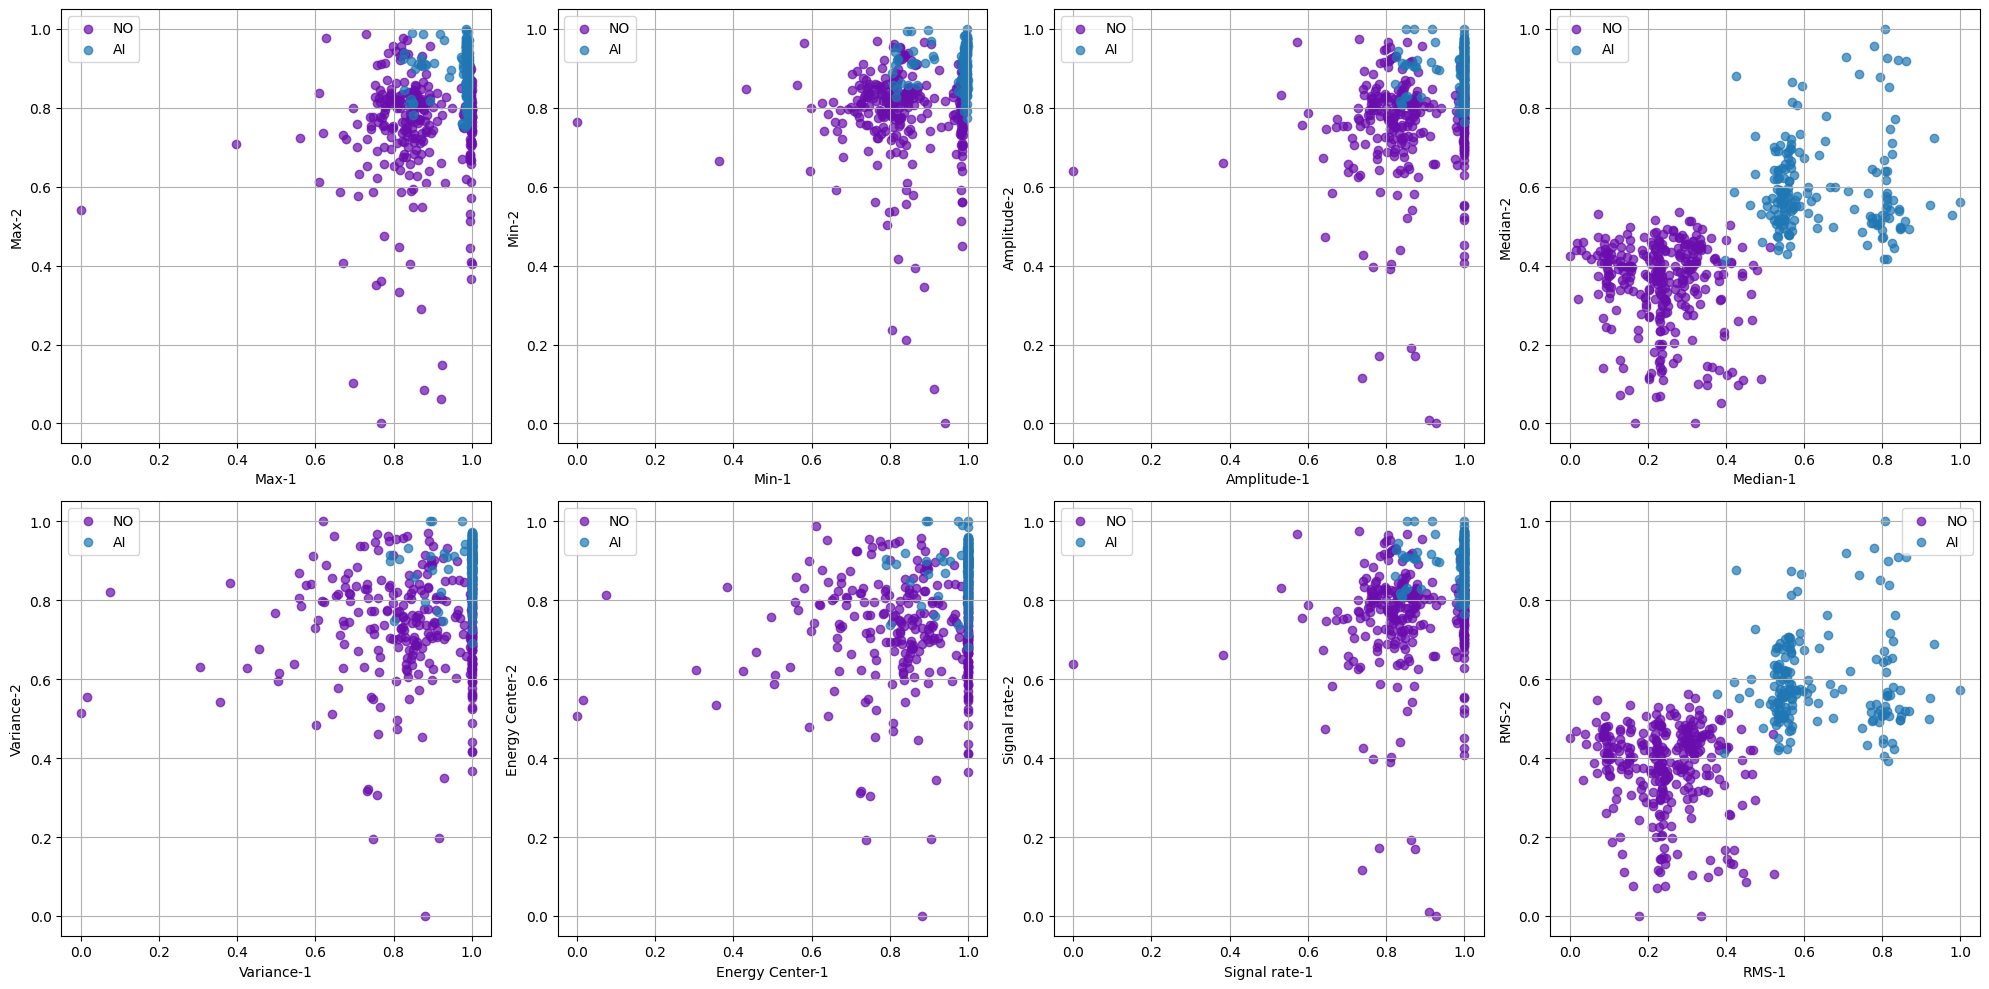

In [9]:
# Function to plot clusters
def plot_combined_clusters_with_subplots(df, n_cols=4):
    features = [col for col in df.columns if col not in ['Label']]
    cluster_labels = df['Label'].unique()

    n_feature_pairs = len(features) // 2 + (len(features) % 2)
    n_rows = -(-n_feature_pairs // n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5), squeeze=False)
    axes = axes.flatten()

    for i in range(0, len(features) - 1, 2):
        feature_x = features[i]
        feature_y = features[i + 1]
        ax = axes[i // 2]

        # Plotting each cluster with the corresponding name and defined colors
        for idx, cluster in enumerate(cluster_labels):
            cluster_data = df[df['Label'] == cluster]
            ax.scatter(cluster_data[feature_x], cluster_data[feature_y],
                       label=f"{cluster}", color=colors[idx], alpha=0.7)

        ax.set_xlabel(feature_x)
        ax.set_ylabel(feature_y)
        ax.legend()
        ax.grid(True)

    if len(features) % 2 != 0:
        feature_x = features[-1]
        ax = axes[-1]

        for idx, cluster in enumerate(cluster_labels):
            cluster_data = df[df['Label'] == cluster]
            ax.scatter(cluster_data[feature_x], cluster_data[feature_x],
                       label=f"{cluster}", color=colors[idx], alpha=0.7)

        ax.set_xlabel(feature_x)
        ax.set_ylabel(feature_x)
        ax.legend(title='Label')
        ax.grid(True)

    for j in range(n_feature_pairs, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Plotting the combined clusters with cluster names and custom colors
plot_combined_clusters_with_subplots(combined_)


#7- Classification and matrics evaluation using SVM, KNN, DT, RF, XGB


In [10]:
#Importing libraries
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR
import xgboost as xgb
import warnings
import matplotlib.colors as mcolors
warnings.filterwarnings('ignore') # Ignore warnings

In [11]:
# Split the data into inputs (x) and outputs (y)
X = dataset.drop(columns=['Label'])
y = dataset['Label']

In [12]:
# Split the data into training and test sets (75% training, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

# Split the training set into training and validation sets (75% training, 25% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, shuffle=True)

# Print the size of each set and the proportion of data
print(f"Training set size: {X_train.shape[0]} ({(X_train.shape[0]/len(X))*100:.1f}%)")
print(f"Validation set size: {X_val.shape[0]} ({(X_val.shape[0]/len(X))*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} ({(X_test.shape[0]/len(X))*100:.1f}%)")

Training set size: 545 (56.2%)
Validation set size: 182 (18.8%)
Test set size: 243 (25.1%)


In [13]:
print(y_test.shape)
print(y_test.value_counts(),'\n')

(243,)
Label
NO    159
AI     84
Name: count, dtype: int64 



#8- Metrics evaluation including confusion matrix, accuracy, cross-valdation, F1-score, precision, and recall.

**SVM**

In [14]:
# Definition and training of the SVM model (One-vs-One with linear kernel)
SVM_OvO = svm.SVC(kernel='linear', C=100, decision_function_shape='ovo')
SVM_OvO.fit(X_train, y_train) # Training the model on the balanced training set

SVC(C=100, decision_function_shape='ovo', kernel='linear')

In [15]:
# Predict the samples for testing set
y_pred = SVM_OvO.predict(X_test)

# Display prediction and the actual value for the second element of the test set
print('Prediction :', y_pred[1])
print('Actual:', y_test.iloc[1])

# Compute and print classification metrics (Accuracy, F1-Score, Precision and Recall)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('\nF1-score:', f1_score(y_test, y_pred, average='micro'))
print('\nPrecision: %.3f' % precision_score(y_test, y_pred,average='micro'))
print('\nRecall: %.3f' % recall_score(y_test, y_pred,average='micro'))

# Print classification report for model
print('\nClassification report:\n')
print(classification_report(y_test, y_pred))

Prediction : AI
Actual: AI
Accuracy: 0.9958847736625515

F1-score: 0.9958847736625515

Precision: 0.996

Recall: 0.996

Classification report:

              precision    recall  f1-score   support

          AI       1.00      0.99      0.99        84
          NO       0.99      1.00      1.00       159

    accuracy                           1.00       243
   macro avg       1.00      0.99      1.00       243
weighted avg       1.00      1.00      1.00       243



In [16]:
# Cross-validation for classification SVM
scores=cross_val_score(SVM_OvO, X, y, cv=5, scoring='accuracy')

# Print cross-validation
print("Cross-validation scores: {}". format(scores))
print("Average cross-validation score: {}". format(scores.mean()))

Cross-validation scores: [0.98453608 1.         0.99484536 0.99484536 0.97938144]
Average cross-validation score: 0.9907216494845361


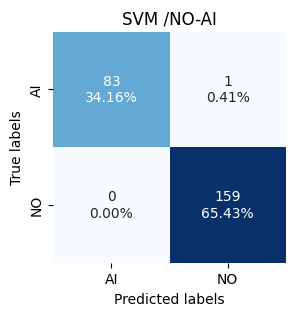

In [17]:
# Creating a Confusion Matrix
cm_SVM = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix KNN
plt.figure(figsize=(3, 3)) #for binary

# Create the count and percentage labels
group_counts = [f"{value:0.0f}" for value in cm_SVM.flatten()]
group_percentages = [f"{value:.2%}" for value in cm_SVM.flatten()/np.sum(cm_SVM)]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
labels = np.asarray(labels).reshape(cm_SVM.shape)

ax =sns.heatmap(cm_SVM, annot=labels, fmt='', cmap='Blues', cbar=False)#multiclass
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');
plt.title('SVM /NO-AI')

# Customizing axis labels to represent classes
ax = plt.gca()
ax.xaxis.set_ticklabels(['AI', 'NO']) #when it is RI, change to RI or when it is AI, change to AI
ax.yaxis.set_ticklabels(['AI', 'NO']) #when it is RI, change to RI or when it is AI, change to AI
#ax.xaxis.set_ticklabels(['AI','FC', 'NO', 'RI'])#for multiclass
#ax.yaxis.set_ticklabels(['AI','FC', 'NO', 'RI'])#for multiclass

# Save the plot
plt.savefig('svm_cm_multiclass.png', format='png', transparent=True, dpi=400, bbox_inches='tight')
plt.show()